In [2]:
import ee
import geemap.core as geemap
ee.Authenticate()
ee.Initialize(project='agtech-suscripci-1759332935027')


# Área de interés (Turipaná, Córdoba)
aoi = ee.Geometry.Rectangle([-75.89, 8.88, -75.86, 8.90])

# Fechas de análisis
start_date = '2022-01-01'
end_date = '2024-03-31'

# Colección MODIS NDVI
modis_ndvi = ee.ImageCollection('MODIS/061/MOD13Q1') \
    .filterDate(start_date, end_date) \
    .filterBounds(aoi) \
    .select('NDVI')

# Validar si hay imágenes disponibles
image_count = modis_ndvi.size().getInfo()
print(f" Número de imágenes encontradas: {image_count}")

if image_count > 0:
    # Calcular NDVI promedio
    ndvi_composite = modis_ndvi.mean().clip(aoi)

    # Exportar imagen a Google Drive
    task = ee.batch.Export.image.toDrive(
        image=ndvi_composite,
        description='MODIS_NDVI_EneMar2024',
        folder='GEE_Exports',
        fileNamePrefix='NDVI_MODIS_Turipana_Marzo2024',
        region=aoi,
        scale=250,
        crs='EPSG:4326',
        maxPixels=1e13
    )
    task.start()
    print("Exportación iniciada a Google Drive.")
else:
    print("No se encontraron imágenes MODIS NDVI para el área y fechas especificadas.")



Successfully saved authorization token.
 Número de imágenes encontradas: 52
Exportación iniciada a Google Drive.


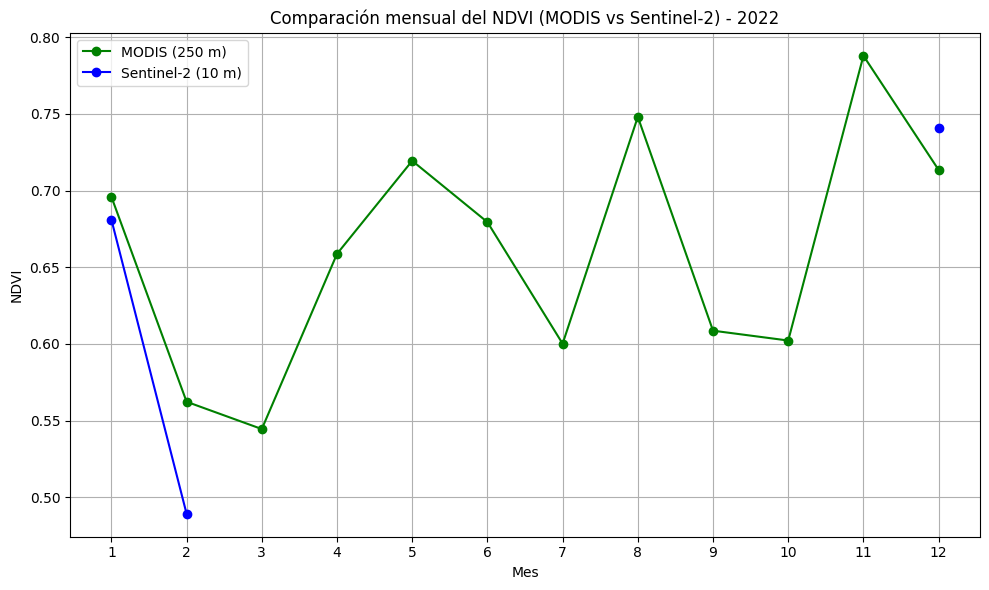

Diferencia promedio S2 - MODIS: -0.020302490500752446


In [4]:
import ee
import geemap
import pandas as pd
import matplotlib.pyplot as plt

# Autenticación e inicialización
ee.Authenticate()
ee.Initialize(project='agtech-suscripci-1759332935027')

# Área de interés (Cereté, Córdoba)
aoi = ee.Geometry.BBox(-75.89, 8.88, -75.86, 8.90)

# Año de análisis
year = 2022
months = list(range(1, 13))

# Función para calcular NDVI mensual
def get_monthly_ndvi(month):
    start = ee.Date.fromYMD(year, month, 1)
    end = start.advance(1, 'month')

    # MODIS
    modis = (
        ee.ImageCollection('MODIS/006/MOD13Q1')
        .filterDate(start, end)
        .filterBounds(aoi)
        .select('NDVI')
    )

    # Sentinel-2
    s2 = (
        ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
        .filterDate(start, end)
        .filterBounds(aoi)
        .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))
        .select(['B4', 'B8'])
    )

    # Get counts of images in collections
    modis_count = modis.size()
    s2_count = s2.size()

    # Initialize values as None
    modis_value = None
    s2_value = None

    # Calculate MODIS mean and reduce only if the collection is not empty
    if modis_count.getInfo() > 0: # Use getInfo() to resolve the size server-side
        modis_mean = modis.mean().multiply(0.0001).rename('NDVI_MODIS')
        modis_value = modis_mean.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=aoi,
            scale=250,
            maxPixels=1e9
        ).get('NDVI_MODIS')

    # Calculate Sentinel-2 NDVI and reduce only if the collection is not empty
    if s2_count.getInfo() > 0: # Use getInfo() to resolve the size server-side
        ndvi_s2 = s2.median().normalizedDifference(['B8', 'B4']).rename('NDVI_S2')
        s2_value = ndvi_s2.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=aoi,
            scale=10,
            maxPixels=1e9
        ).get('NDVI_S2')


    return ee.Feature(None, {
        'month': month,
        'NDVI_MODIS': modis_value,
        'NDVI_S2': s2_value
    })

# Crear FeatureCollection mensual
features = ee.FeatureCollection([get_monthly_ndvi(m) for m in months])

# 🔁 Alternativa manual: convertir a lista de diccionarios
fc_info = features.getInfo()
features_list = [f['properties'] for f in fc_info['features']]

# Convertir a DataFrame
data = pd.DataFrame(features_list)
data['month'] = data['month'].astype(int)

# Graficar
plt.figure(figsize=(10, 6))
plt.plot(data['month'], data['NDVI_MODIS'], label='MODIS (250 m)', marker='o', color='green')
plt.plot(data['month'], data['NDVI_S2'], label='Sentinel-2 (10 m)', marker='o', color='blue')

plt.title(f'Comparación mensual del NDVI (MODIS vs Sentinel-2) - {year}')
plt.xlabel('Mes')
plt.ylabel('NDVI')
plt.xticks(months)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

data['diferencia'] = data['NDVI_S2'] - data['NDVI_MODIS']
print("Diferencia promedio S2 - MODIS:", data['diferencia'].mean())


